In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cellpose import models, io, plot, utils
from skimage import measure
import napari
from  mfish.utils.load import parse_filename

# for nicer looking plots
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [2]:
# if running the notebook without installing the package, comment out the following lines, and declare paths as a dictionary shown below
dataset = 'RH3-1'
try:
    from  mfish.utils.load import load_config
    paths = load_config(dataset)
    print('paths successfully loaded from config.toml')
except:
    print('Using manually specified paths')
    paths = {'data': '', 
            'images': '', 
            'results': ''}

for k, v in paths.items():
    print(f'{k}: {v}')

Paths are for dataset tagged: RH3-1
paths successfully loaded from config.toml
data: /users/polina.kosillo/Local/code/mfish/data
images: /users/polina.kosillo/Local/code/mfish/data/RH3-1_19Oct23
results: /users/polina.kosillo/Local/code/mfish/data/results
package_dir: /Users/polina.kosillo/Local/code/mfish
config_file: /Users/polina.kosillo/Local/code/mfish/config.toml


In [3]:
# Create directory within results for the particular dataset
paths['results'] =  pathlib.Path(paths['results'], dataset)
pathlib.Path(paths['results']).mkdir(parents=True, exist_ok=True)
print(paths['results'])

/users/polina.kosillo/Local/code/mfish/data/results/RH3-1


In [4]:
# #f = lambda x: x**2
# #g = lambda x: f(f(x)) # this is actually a function, that returns x**4
# get_zplane = lambda fname: parse_filename(fname)[1]
# # zplane is a function - output of zplane(filename) is a string
# print(get_zplane('C1-MAX_Stitch_A01_G001_10-20.tif'))

In [5]:
im_file_list = [f for f in os.listdir(paths['images']) if f.endswith('.tif') and f.startswith('C1')]
get_zplane = lambda fname: parse_filename(fname)[1]
im_file_list = sorted(im_file_list, key=get_zplane)
for f in im_file_list: print(f)

C1-MAX_Stitch_A01_G001_25-35.tif
C1-MAX_Stitch_A01_G001_36-46.tif
C1-MAX_Stitch_A01_G001_47-57.tif
C1-MAX_Stitch_A01_G001_58-68.tif
C1-MAX_Stitch_A01_G001_69-79.tif
C1-MAX_Stitch_A01_G001_80-90.tif
C1-MAX_Stitch_A01_G001_91-101.tif


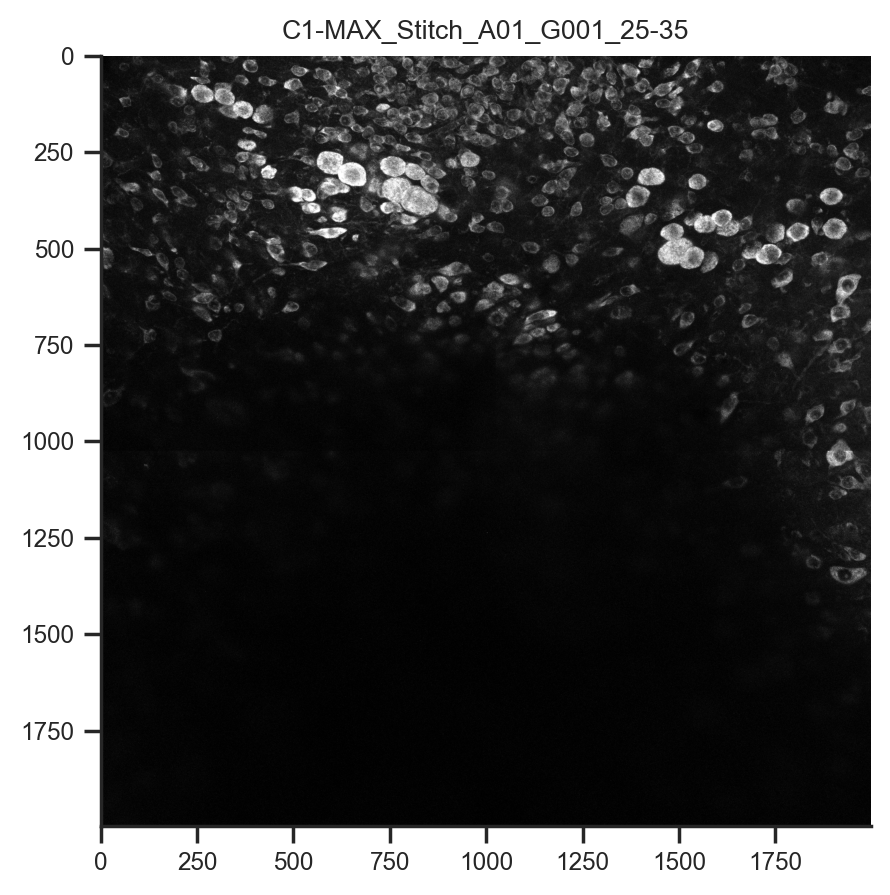

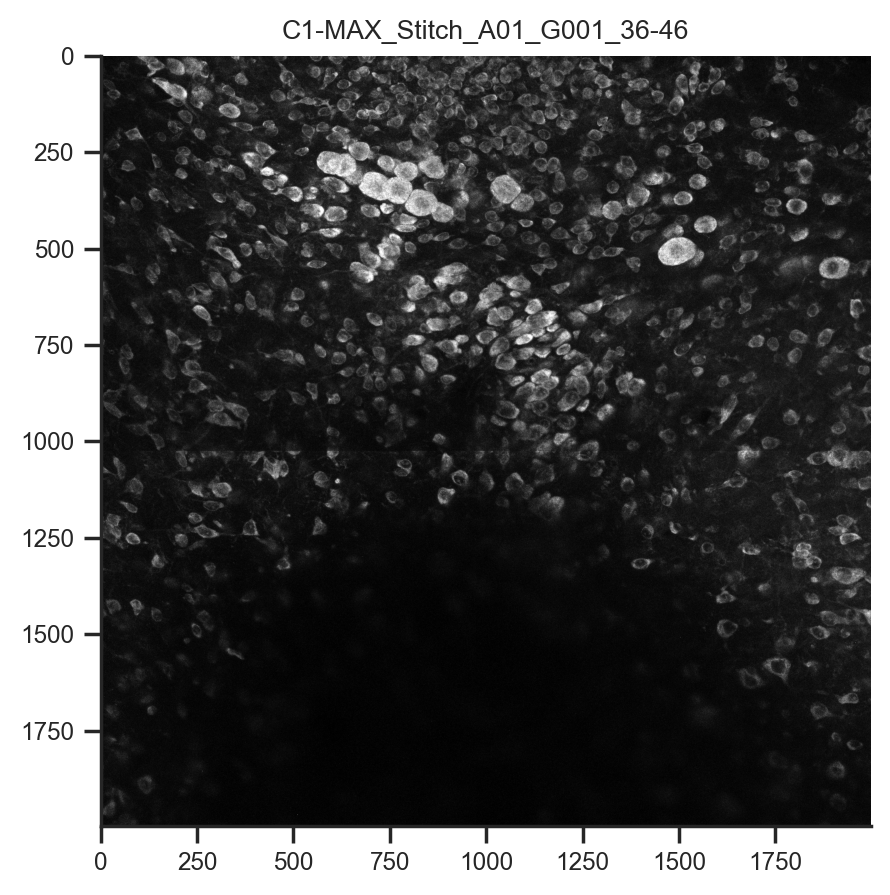

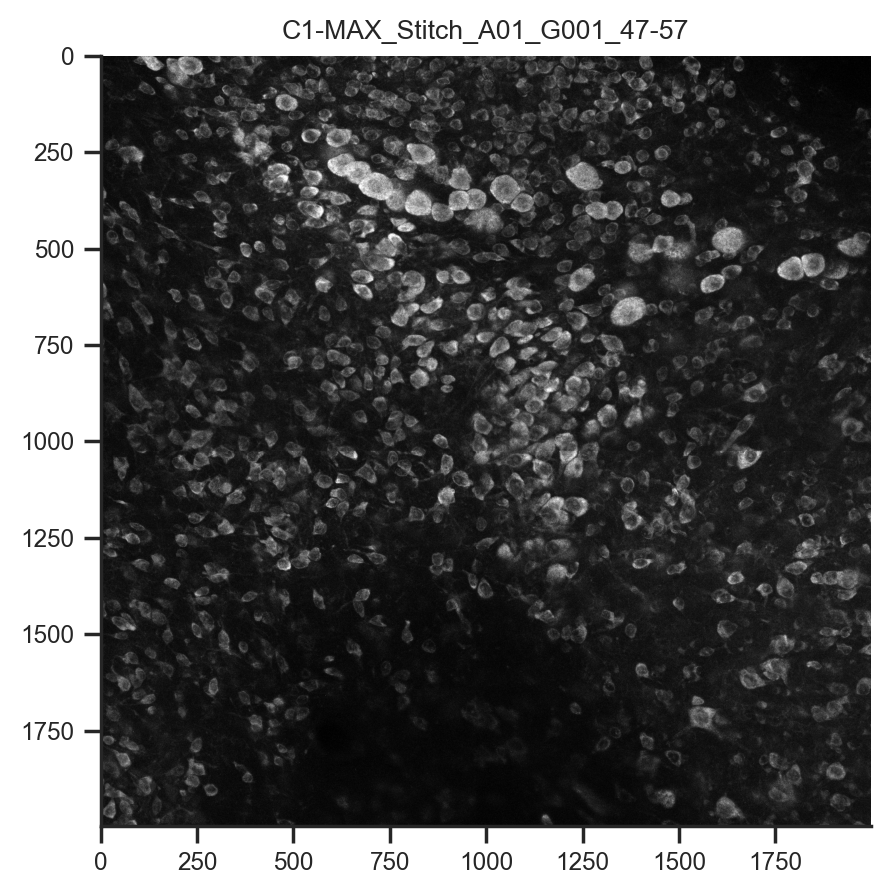

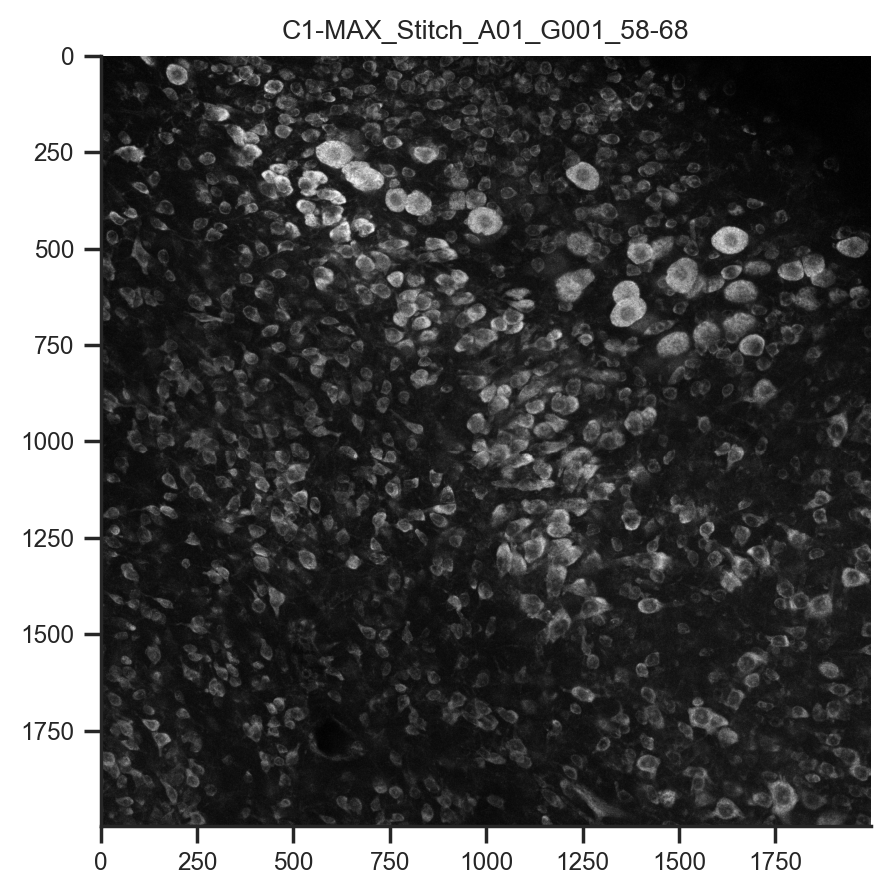

In [6]:
# show the different z planes
im_file_list = im_file_list[:4]
for file in im_file_list:
    im_name = file.replace('.tif', '')
    im = io.imread(paths['images'] + f'/{file}')

    f, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(im, cmap='gray')
    ax.set(title=im_name)
    plt.show()

In [7]:
# Select a channel to segment this dataset
im_name = "C1-MAX_Stitch_A01_G001_58-68"
channel, zplane = parse_filename(im_name)
im = io.imread(paths['images'] + f'/{im_name}.tif')

In [8]:
# channels=[0,0] for grayscale image
model = models.Cellpose(gpu=False, model_type='cyto2')
masks, flows, styles, diams = model.eval(im, diameter=None, channels=[0,0], flow_threshold=0.4, do_3D=False)

# utils.outlines_list puts x,y coordinates for outline of the k-th cell is in outline[k]
outlines = utils.outlines_list(masks)

In [9]:
fname = str(paths['results'] / f'{channel}_{zplane}')
io.outlines_to_text(base=fname, outlines=outlines)
print(f'Outline file saved as {fname}_cp_outlines.txt')

Outline file saved as /users/polina.kosillo/Local/code/mfish/data/results/RH3-1/C1_58-68_cp_outlines.txt


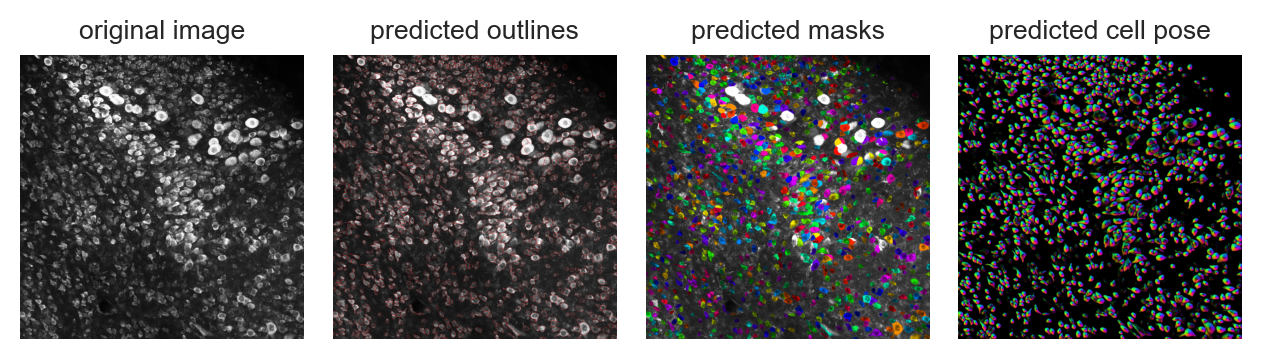

In [10]:
f = plt.figure()
plot.show_segmentation(f, im, masks, flows[0], channels=[0, 0], file_name=f'{fname}_seg_summary')
plt.tight_layout()
plt.show()

# optional; only needed to save intermediate calculations.
# io.masks_flows_to_seg(im, masks, flows, diams, fname + 'flows')

In [11]:
print(f'Number of unique mask values: {np.size(np.unique(masks))}')
print('mask=0 corresponds to background')

# generate binary masks
fg_mask = (masks!=0).astype(int)
bg_mask = (masks==0).astype(int)

Number of unique mask values: 1050
mask=0 corresponds to background


In [12]:
# Get images corresponding to other C2, C3, C4 etc.
channel, zplane = parse_filename(im_name)
im_file_list = [file for file in os.listdir(paths['images']) if zplane in file]
get_channels = lambda fname: parse_filename(fname)[0]
im_file_list = sorted(im_file_list, key=get_channels)
for file in im_file_list: print(file)

C1-MAX_Stitch_A01_G001_58-68.tif
C2-MAX_Stitch_A01_G001_58-68.tif
C3-MAX_Stitch_A01_G001_58-68.tif
C4-MAX_Stitch_A01_G001_58-68.tif
C5-MAX_Stitch_A01_G001_58-68.tif


In [13]:
# masks == 0 is background according to cellpose
# regionprops_table ignores masks = 0 values (assumes it is background)
cells_df = measure.regionprops_table(masks, properties=['label','centroid', 'area', 'eccentricity'])
cells_df = pd.DataFrame(cells_df)
cells_df.rename(columns={'centroid-0':'x', 'centroid-1':'y'}, inplace=True)

df_dict = {}
for file in im_file_list:
    ch_name = file[:2]
    ch_im = io.imread(paths['images'] + f'/{file}')
    # calculates properties of each unique mask region (i.e. cells, if the segmentation is decent)
    # the same masks are used for all channels, so the dataframe will contain the same label set across channels

    props = measure.regionprops_table(masks, intensity_image=ch_im, properties=['label','mean_intensity', 'max_intensity', 'min_intensity'])
    props = pd.DataFrame(props)
    props.rename(columns={'mean_intensity':f'{ch_name}_fg'}, inplace=True)
    props.rename(columns={'max_intensity':f'{ch_name}_max_intensity'}, inplace=True)
    props.rename(columns={'min_intensity':f'{ch_name}_min_intensity'}, inplace=True)
    props[f'{ch_name}_bg_mean'] = np.mean(ch_im * bg_mask)
    props[f'{ch_name}_bg_std'] = np.std(ch_im * bg_mask)
    cells_df = cells_df.merge(props, on='label', how='left')

In [14]:
cells_df.to_csv(f'{fname}_cells_df.csv', index = False)

In [15]:

# Add a column that calculates dimensions of the mask.
# Example criteria to consider:
# Some masks are too small or too large to be cells "area" in pixels.
# Some masks are too "skinny" (ratio of axis_minor_length/axis_major_length is too small)
print(cells_df.shape)
cells_df.head(4)

(1049, 30)


label          x           y   area  eccentricity        C1_fg  \
0      1  11.462299  124.819530  809.0      0.828489  1479.070457   
1      2   9.859606  336.493842  812.0      0.888060   821.974138   
2      3  12.059197  401.766385  946.0      0.826483  1007.948203   
3      4   5.323899  600.896226  318.0      0.900399   947.305031   

   C1_max_intensity  C1_min_intensity  C1_bg_mean  C1_bg_std  ...       C4_fg  \
0            4062.0             219.0   333.42248   358.6174  ...   77.585909   
1            1909.0             267.0   333.42248   358.6174  ...   99.168719   
2            2655.0             329.0   333.42248   358.6174  ...  101.050740   
3            2098.0             265.0   333.42248   358.6174  ...  144.663522   

   C4_max_intensity  C4_min_intensity  C4_bg_mean  C4_bg_std       C5_fg  \
0             356.0              36.0   70.820964   76.18608  874.838072   
1             733.0              35.0   70.820964   76.18608   74.667488   
2             615.0              36.0   70.820964   76.18608   73.180761   
3            1169.0              37.0   70.820964   76.18608   69.292453   

   C5_max_intensity  C5_min_intensity  C5_bg_mean   C5_bg_std  
0            3280.0              40.0   92.319009  157.701557  
1             857.0              34.0   92.319009  157.701557  
2             698.0              34.0   92.319009  157.701557  
3             525.0              34.0   92.319009  157.701557  

[4 rows x 30 columns]

In [16]:
# example with channel 1:
ch = 5
pass_criteria = cells_df[f'C{ch}_fg'] > cells_df[f'C{ch}_bg_mean'] + 1.25 * cells_df[f'C{ch}_bg_std']
cells_df_pass = cells_df[pass_criteria]
print(cells_df_pass.shape)
cells_df_pass.head(4)

(178, 30)


label           x           y    area  eccentricity        C1_fg  \
0        1   11.462299  124.819530   809.0      0.828489  1479.070457   
103    104  135.625229  331.404022   547.0      0.967980  1053.131627   
105    106  148.548307  311.597853  1211.0      0.679625  2359.728324   
116    117  154.710327  281.557935   794.0      0.703301  1015.770781   

     C1_max_intensity  C1_min_intensity  C1_bg_mean  C1_bg_std  ...  \
0              4062.0             219.0   333.42248   358.6174  ...   
103            2793.0             290.0   333.42248   358.6174  ...   
105            4095.0             663.0   333.42248   358.6174  ...   
116            2361.0             230.0   333.42248   358.6174  ...   

          C4_fg  C4_max_intensity  C4_min_intensity  C4_bg_mean  C4_bg_std  \
0     77.585909             356.0              36.0   70.820964   76.18608   
103   83.303473             348.0              36.0   70.820964   76.18608   
105  109.134600             659.0              35.0   70.820964   76.18608   
116   92.205290             413.0              36.0   70.820964   76.18608   

           C5_fg  C5_max_intensity  C5_min_intensity  C5_bg_mean   C5_bg_std  
0     874.838072            3280.0              40.0   92.319009  157.701557  
103   521.312614            1871.0              39.0   92.319009  157.701557  
105  1175.863749            3282.0             158.0   92.319009  157.701557  
116   523.429471            2645.0              34.0   92.319009  157.701557  

[4 rows x 30 columns]

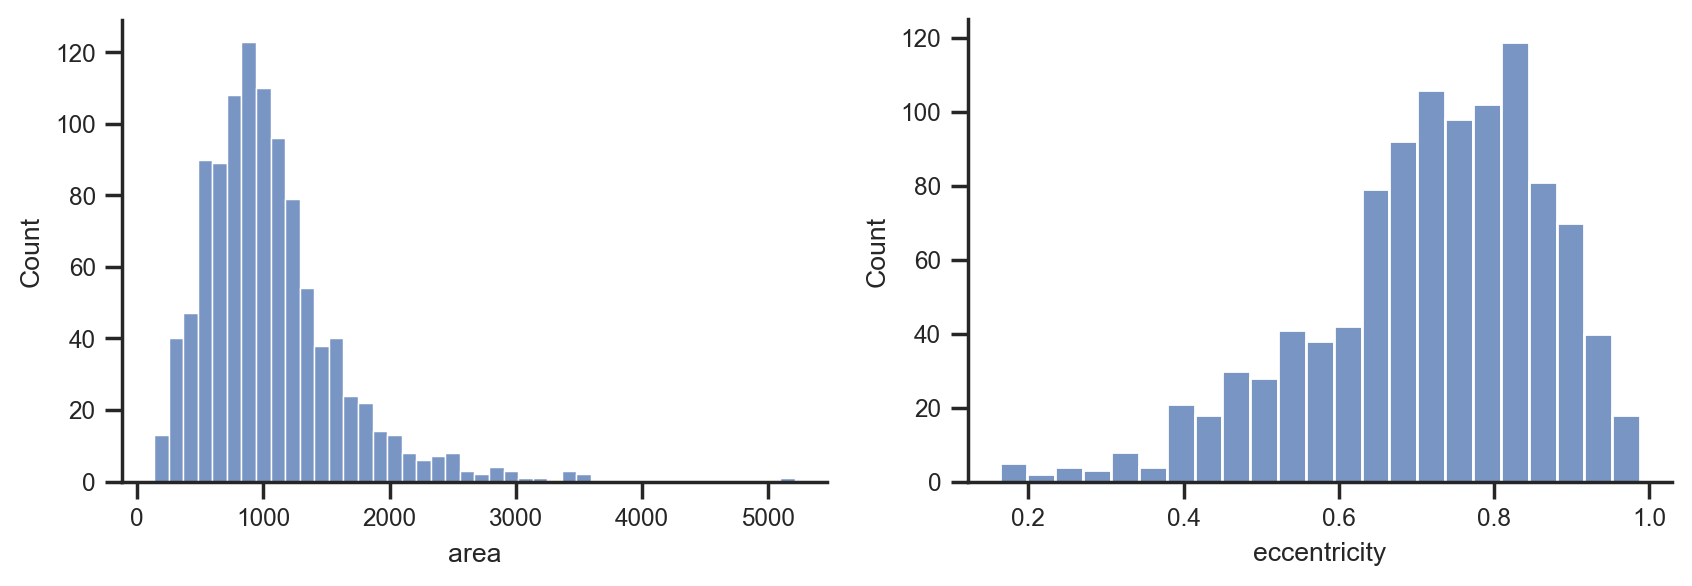

In [17]:
# show distributions of area and eccentricity
f, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(cells_df['area'], ax=ax[0])
sns.histplot(cells_df['eccentricity'], ax=ax[1])
plt.show()

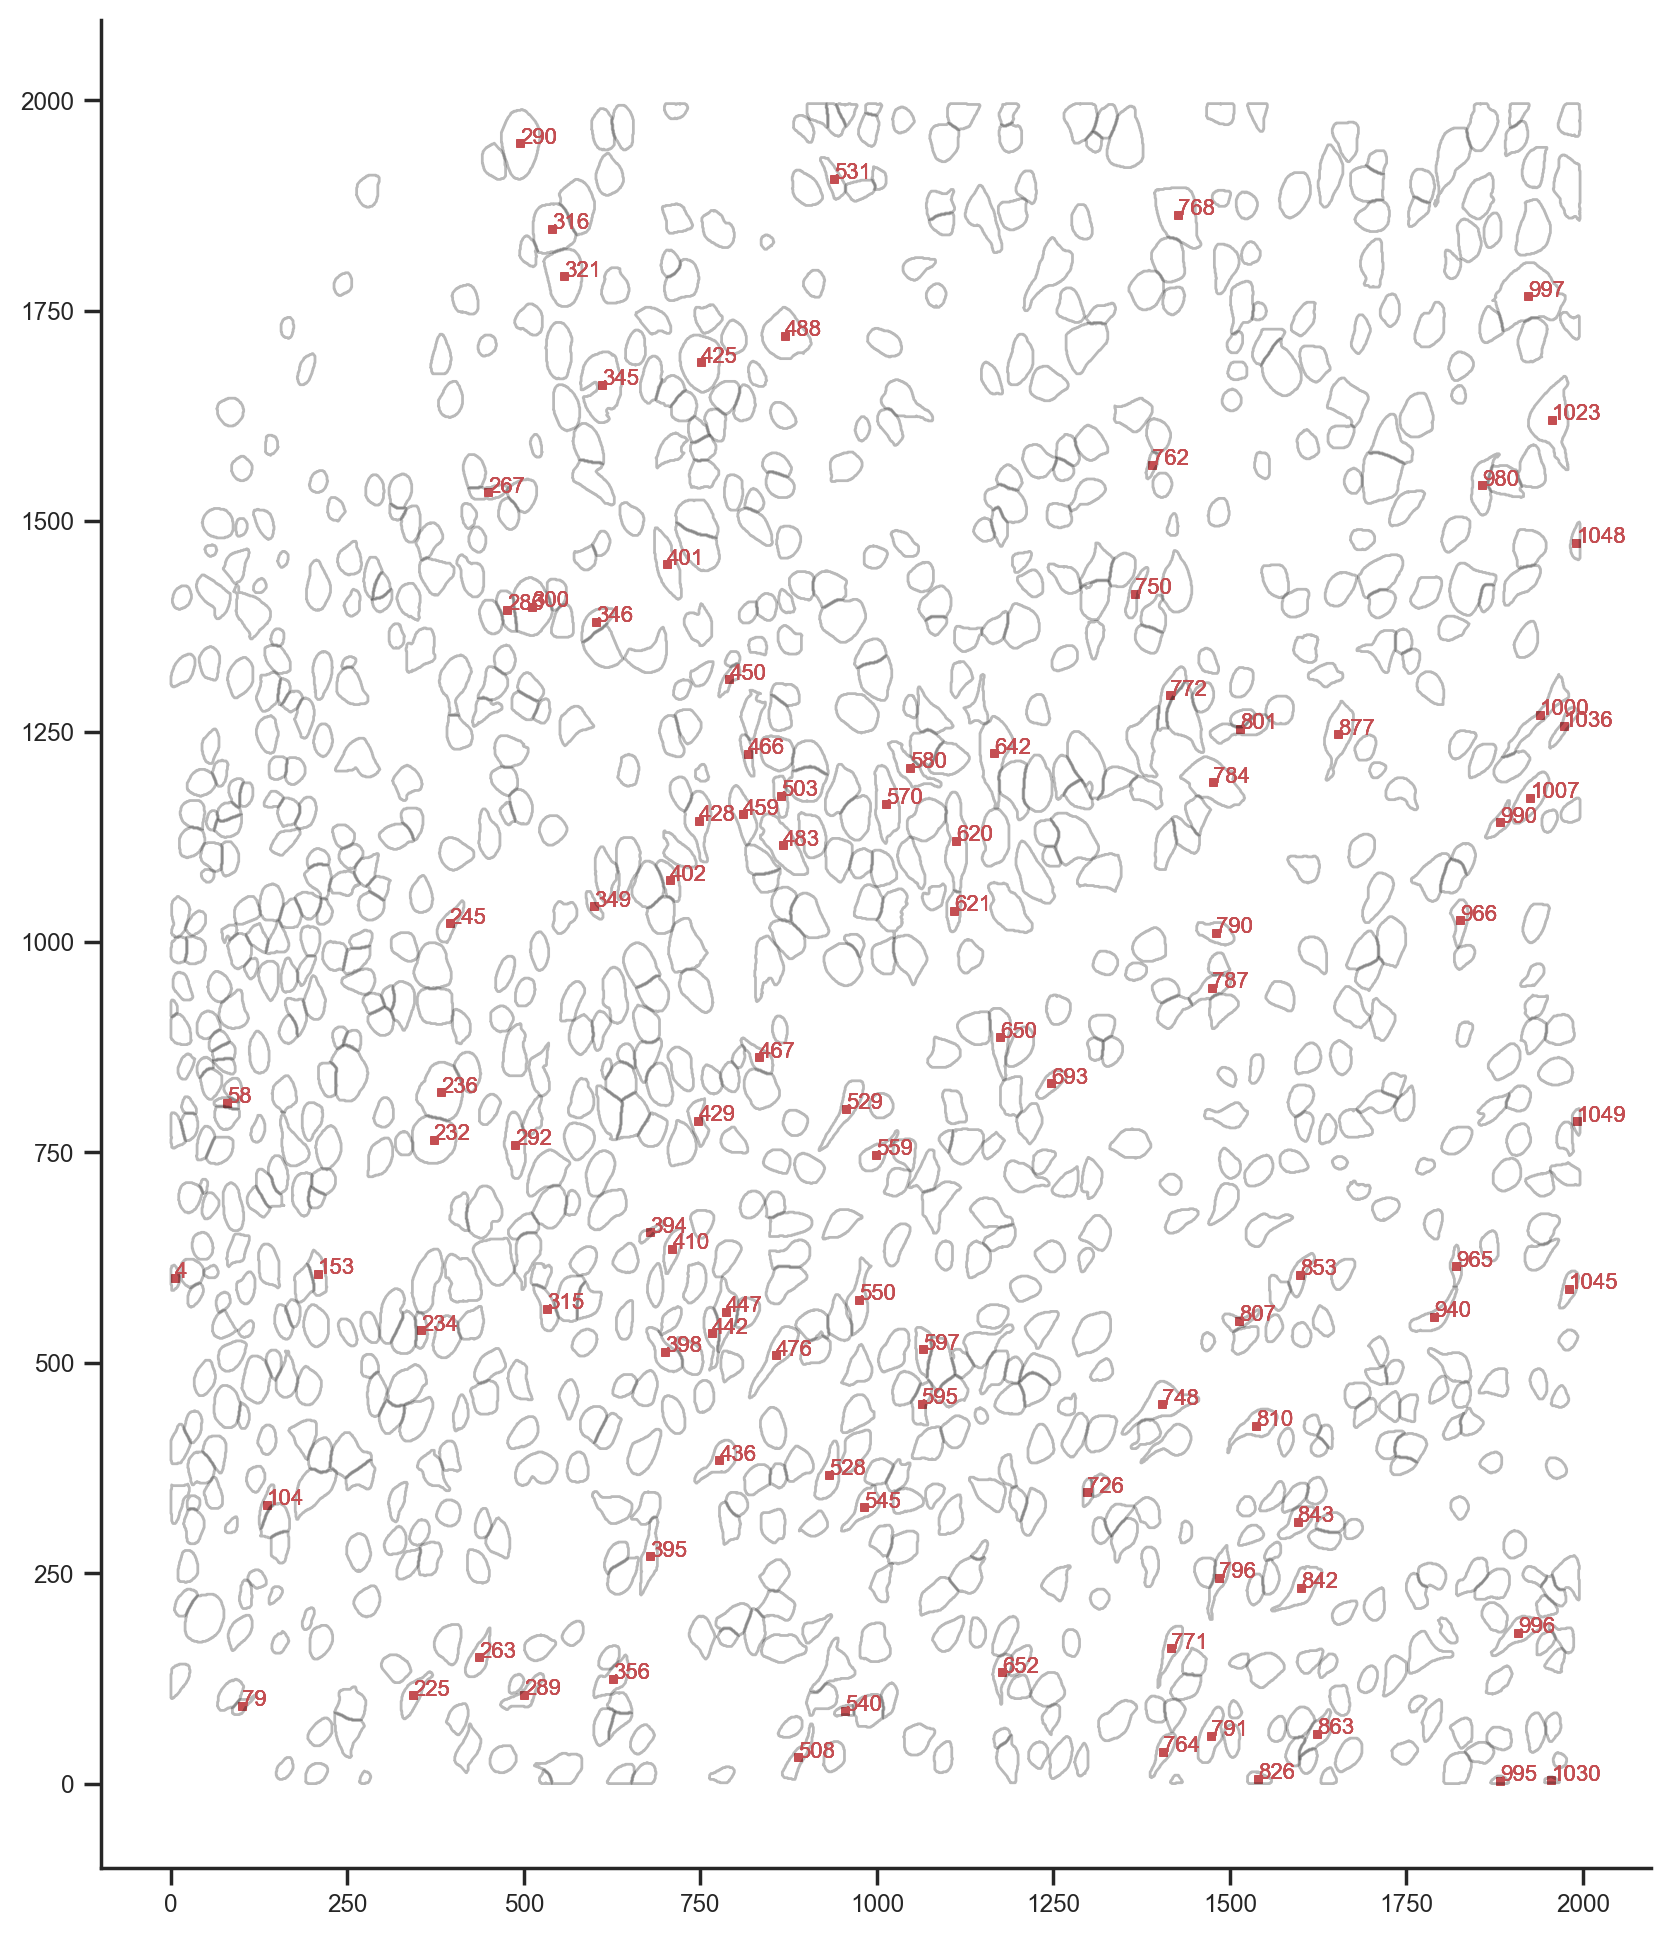

In [18]:
f, ax = plt.subplots(figsize=(10, 12))
# draw outlines
for cell in range(len(outlines)):
    ax.plot(outlines[cell][:, 1], outlines[cell][:, 0], linewidth=1, c='k', alpha=0.3)

for ch in [1,2,3,4,5]:
    fail_criteria_1 = cells_df['eccentricity'] > 0.9
    fail_criteria_2 = cells_df['area'] < 120
    fail_criteria_3 = cells_df['area'] > 2800
    fail_criteria = fail_criteria_1 | fail_criteria_2 | fail_criteria_3
    cells_df_fail = cells_df[fail_criteria]
    ax.scatter(cells_df_fail['x'], cells_df_fail['y'], s=5, marker='s', c='r')
    # annotate with label
    for i, row in cells_df_fail.iterrows():
        ax.annotate(row['label'].astype(int), (row['x'], row['y']), color='r', fontsize=8)
plt.show()

In [19]:
## keep only cells that pass the criteria
#cells_df = cells_df[~fail_criteria]

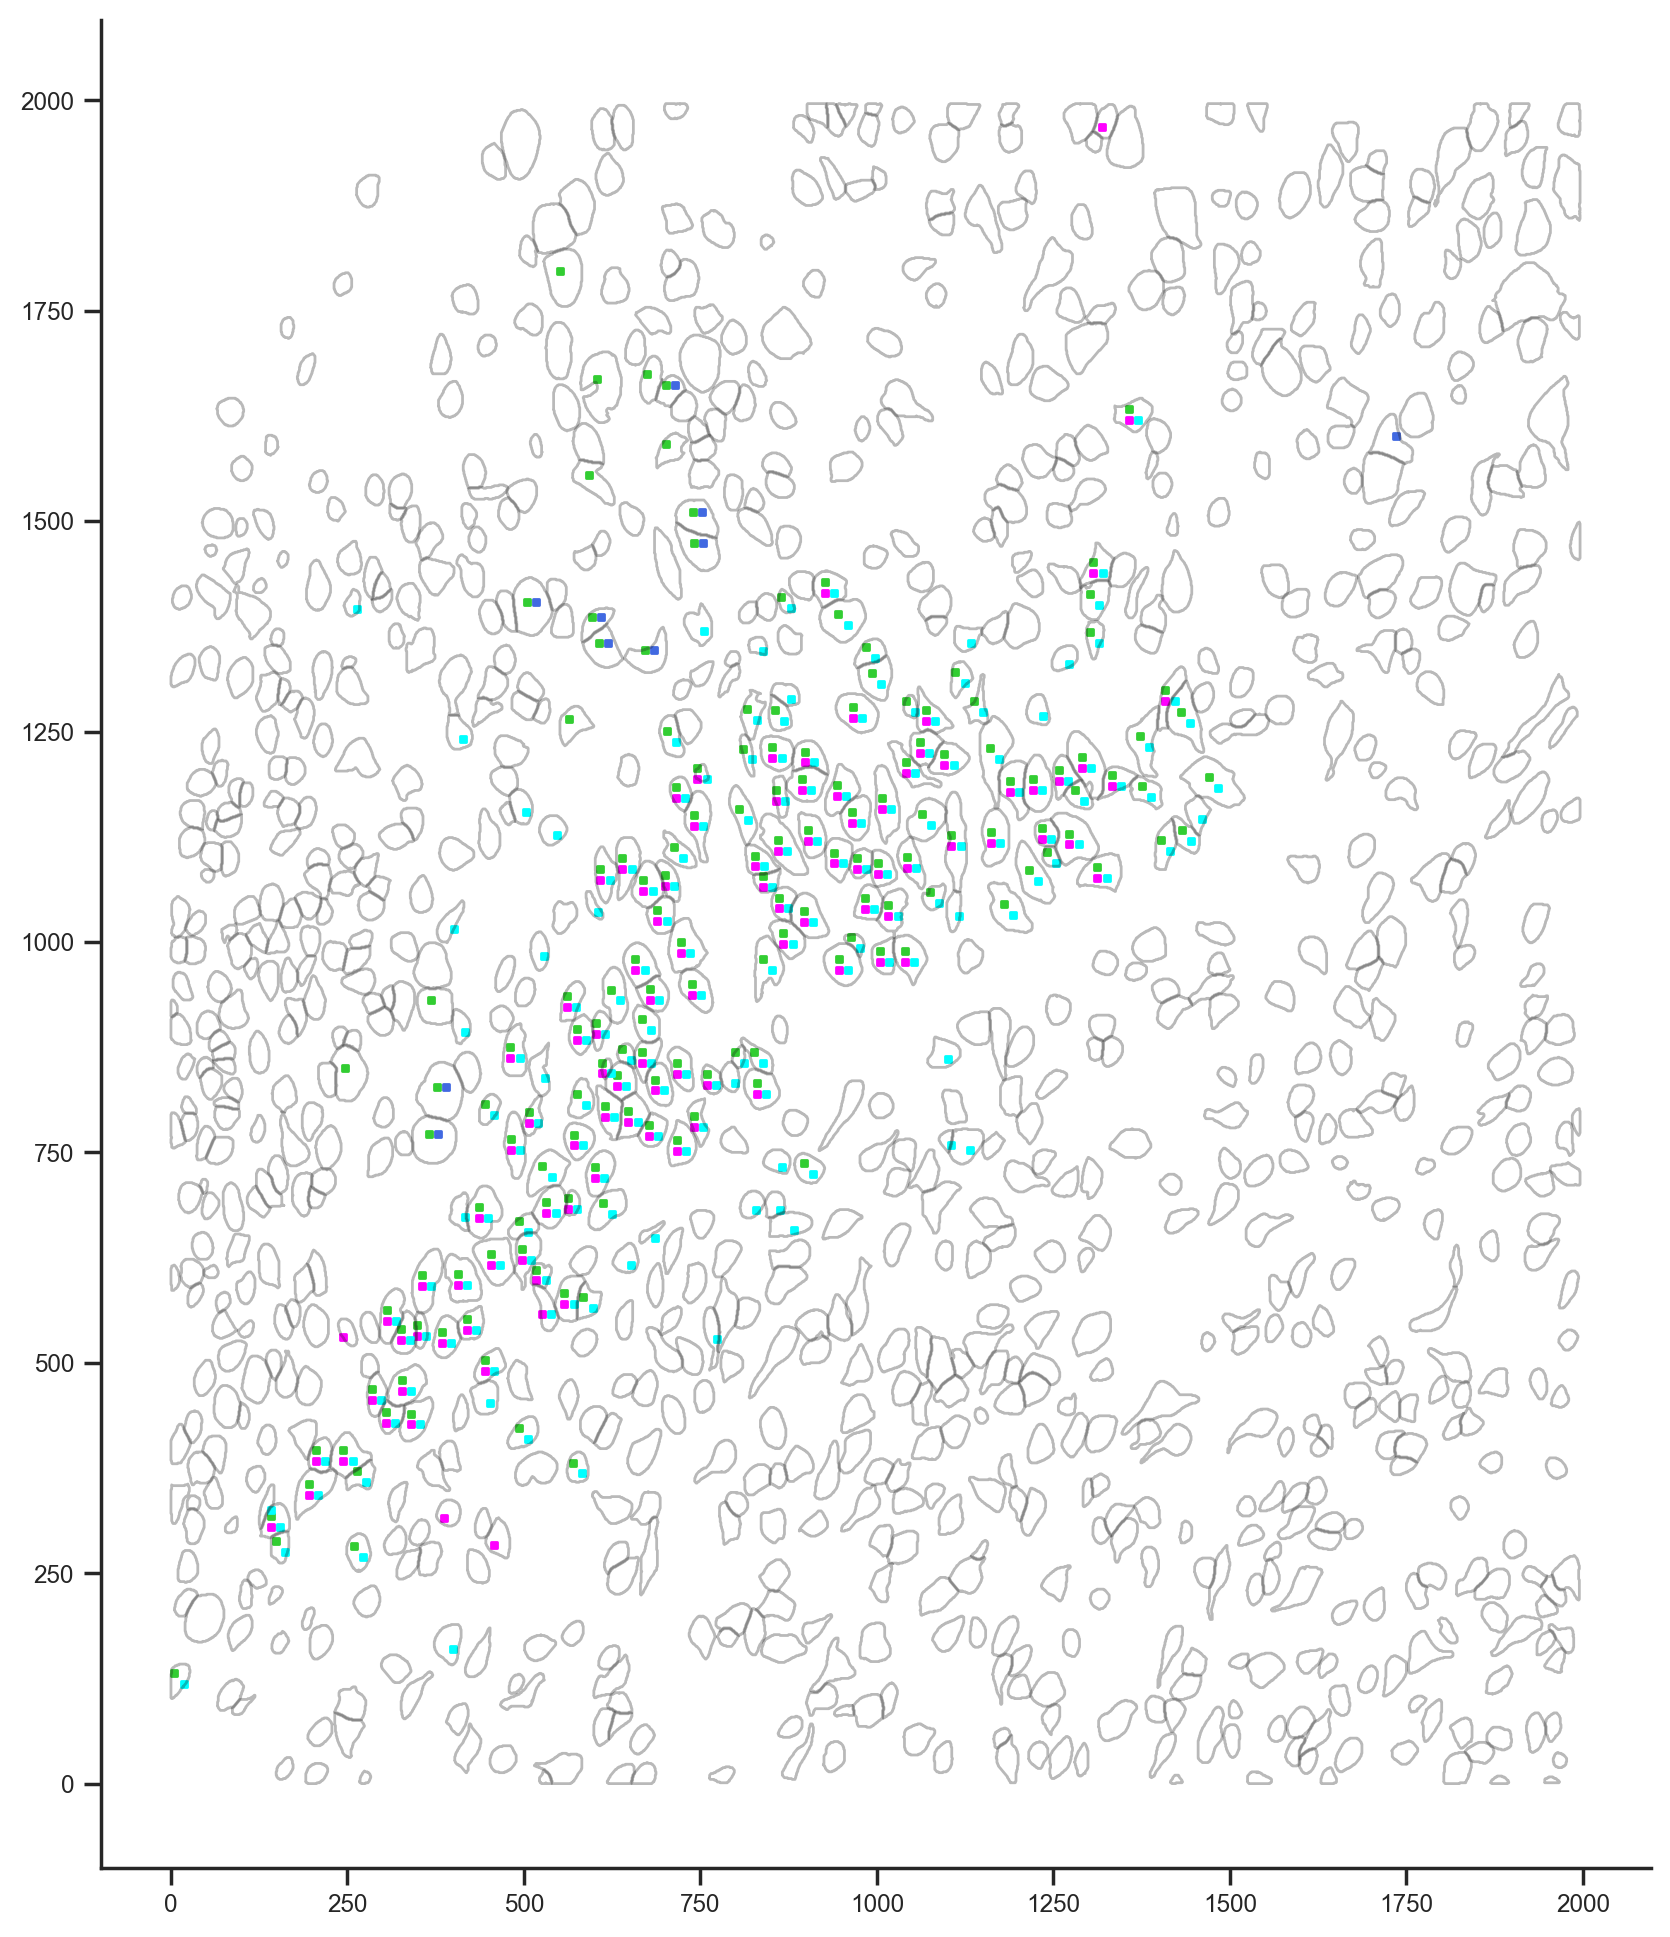

In [20]:
f, ax = plt.subplots(figsize=(10, 12))
# draw outlines
for cell in range(len(outlines)):
    ax.plot(outlines[cell][:, 1], outlines[cell][:, 0], linewidth=1, c='k', alpha=0.3)

ch_offsets = np.array([(-1,-1), (-1, 1), (1, 1), (1, -1)])
ch_offsets = 6.5*ch_offsets

colors = ['magenta', 'limegreen', 'royalblue', 'cyan']
for i, ch in enumerate([2,3,4,5]):
    offset = ch_offsets[i]
#for ch in [2,3,4,5]:
#    offset = ch_offsets[ch-1]
    # criteria for showing positive signal on a cell
    pass_criteria = cells_df[f'C{ch}_fg'] > cells_df[f'C{ch}_bg_mean'] + 1.25 * cells_df[f'C{ch}_bg_std']
    cells_df_pass = cells_df[pass_criteria]
    ax.scatter(cells_df_pass['x'] + offset[0], cells_df_pass['y'] + offset[1], s=5, marker='s', c=colors[i])
#    ax.scatter(cells_df_pass['x'] + offset[0], cells_df_pass['y'] + offset[1], s=5, marker='s', c=colors[ch-1])
plt.savefig(f'{fname}_positive_cells' + '.png', dpi=300, format='png')
plt.show()

In [21]:
!tree ../data/results/RH3-1

../data/results/RH3-1
├── C1_58-68_cells_df.csv
├── C1_58-68_cp_outlines.txt
├── C1_58-68_positive_cells.png
├── C1_58-68_seg_summary_flows.jpg
├── C1_58-68_seg_summary_outlines.jpg
└── C1_58-68_seg_summary_overlay.jpg

1 directory, 6 files
